In [1]:
import sys
import sklearn
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import random as python_random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import *

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from torch import optim

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

## Class Analysis

In [3]:
!pwd

/sfs/qumulo/qhome/hso6b/DL


In [11]:
covidDataPath='dl_data_2/dl_data/Covid_img'
pneumoniaDataPath='dl_data_2/dl_data/Viral_img'
normalDataPath='dl_data_2/dl_data/Normal_img'

In [12]:
# Lists for access paths
listCovidPaths = []
listViralPaths=[]
listNormalPaths = []

# Get covid images files paths
for root, directories, files in os.walk(covidDataPath):
    for name in files:
        listCovidPaths.append(os.path.join(root, name))

for root, directories, files in os.walk(pneumoniaDataPath):
    for name in files:
        listViralPaths.append(os.path.join(root, name))        
        
# Get normal images files paths
for root, directories, files in os.walk(normalDataPath):
    for name in files:
        listNormalPaths.append(os.path.join(root, name))

In [4]:
data_path = 'dl_data_2/dl_data/'
class_names = os.listdir(data_path)

In [5]:
class_names

['Covid_img', 'Viral_img', 'Normal_img']

In [34]:
#class_names = class_names[-3:]
#class_names

['Covid_img', 'Viral_img', 'Normal_img']

In [6]:
class_dist = {}
for c in class_names:
    class_dist[c] = len(os.listdir(data_path + c))
    print(c)
    print(class_dist[c])

Covid_img
3249
Viral_img
1211
Normal_img
9173


In [31]:
import math

def pull_val(dir_path, val_path, portion):
    # get a list of files to hold out for validation
    files = os.listdir(dir_path)
    length = len(files)
    num_files = math.floor(length * portion)
    val_files = np.random.choice(files, size=num_files, replace=False)

    # move files
    for f in val_files:
        os.rename(dir_path + '/' + f, val_path + '/' + f)

In [36]:
# if you need to, use this to make a new directory
os.mkdir('dl_data_2/HOLD_data')
os.mkdir('dl_data_2/test_data')
for c in class_names:
    os.mkdir('dl_data_2/HOLD_data/' + c)
    os.mkdir('dl_data_2/test_data/' + c)

In [37]:
# save out holdout and testing data
portion = .10 # portion of data set aside for HOLDOUT
    
for c in class_names:
    dir_path = 'dl_data_2/dl_data/' + c
    val_path = 'dl_data_2/HOLD_data/' + c
    pull_val(dir_path, val_path, portion)

## Load Data

In [8]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image

#### calculate class weights

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = sum(class_dist.values())
weight_for_0 = (1 / class_dist[class_names[0]]) * (total / 2.0)
weight_for_1 = (1 / class_dist[class_names[1]]) * (total / 2.0)
weight_for_2 = (1 / class_dist[class_names[2]]) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

# directories
data_dir = "dl_data_2/dl_data"

# test_dir = "../test_data"
HOLD_dir = "dl_data_2/HOLD_data"

batch_size = 32;

# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;
    
# data augmentation (for training only)
train_data_gen = ImageDataGenerator(rescale=1./255,
                                    zoom_range= 0.3, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    rotation_range = 30,
                                    validation_split=0.2)

train_ds = train_data_gen.flow_from_directory(
    directory = data_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    follow_links=False,
    subset='training',
    interpolation='nearest'
)

validation_ds = train_data_gen.flow_from_directory(
    directory=data_dir,  # same directory because we are splitting the data here
    follow_links=False,
    subset='validation',
    interpolation='nearest',
    target_size=(img_height, img_width), 
    class_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=batch_size
)


test_data_gen = ImageDataGenerator(rescale=1./255)


# holdout data
HOLD_ds = test_data_gen.flow_from_directory(directory=HOLD_dir, 
                                            target_size=(img_height, img_width), 
                                            class_mode='categorical',
                                            shuffle=True,
                                            seed=42,
                                            batch_size=batch_size)

Found 10908 images belonging to 3 classes.
Found 2725 images belonging to 3 classes.
Found 1514 images belonging to 3 classes.


In [75]:
class_ind = (train_ds.class_indices)
class_ind

{'Covid_img': 0, 'Normal_img': 1, 'Viral_img': 2}

In [6]:
# set checkpoint to resume training if it stops unexpectedly
checkpoint_path = "../checkpoints/training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## VGG-19

In [10]:
base_model_1 = keras.applications.VGG19(weights='imagenet', include_top=False)
n_classes = 3

# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model_1.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
# x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="pred")(x) # match number of classes

model_1 = keras.models.Model(inputs=base_model_1.input,
                             outputs=outputs)

In [13]:
# train up the top layer first
for layer in base_model_1.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.01, decay=0.01)
model_1.compile(loss="categorical_crossentropy", optimizer=optimizer,
                metrics=["accuracy"])
history = model_1.fit(train_ds,
                      validation_data=validation_ds,
                      class_weight=class_weights,
                      epochs=20)

Epoch 1/20


2022-04-30 15:59:04.106950: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


341/341 [==============================] - 409s 1s/step - loss: 1.4808 - accuracy: 0.7517 - val_loss: 0.8439 - val_accuracy: 0.6738
Epoch 2/20
341/341 [==============================] - 161s 472ms/step - loss: 1.2178 - accuracy: 0.7800 - val_loss: 0.4921 - val_accuracy: 0.7960
Epoch 3/20
341/341 [==============================] - 162s 475ms/step - loss: 1.1865 - accuracy: 0.7890 - val_loss: 0.4490 - val_accuracy: 0.8283
Epoch 4/20
341/341 [==============================] - 161s 473ms/step - loss: 1.1825 - accuracy: 0.7852 - val_loss: 0.4263 - val_accuracy: 0.8257
Epoch 5/20
341/341 [==============================] - 162s 474ms/step - loss: 1.1781 - accuracy: 0.7872 - val_loss: 0.4448 - val_accuracy: 0.8139
Epoch 6/20
341/341 [==============================] - 160s 467ms/step - loss: 1.1470 - accuracy: 0.7956 - val_loss: 0.4116 - val_accuracy: 0.8371
Epoch 7/20
341/341 [==============================] - 163s 478ms/step - loss: 1.1626 - accuracy: 0.7880 - val_loss: 0.4334 - val_accuracy:

In [21]:
optimizer = keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, decay=0.01)
model_1.compile(loss="categorical_crossentropy", optimizer=optimizer,
                metrics=["accuracy"])
history = model_1.fit(train_ds,
                      validation_data=validation_ds, 
                      class_weight=class_weights,
                      epochs=5)

Epoch 1/5
341/341 [==============================] - 165s 481ms/step - loss: 2.6075 - accuracy: 0.7492 - val_loss: 0.5506 - val_accuracy: 0.7677
Epoch 2/5
341/341 [==============================] - 163s 479ms/step - loss: 1.2859 - accuracy: 0.7717 - val_loss: 0.4337 - val_accuracy: 0.8073
Epoch 3/5
341/341 [==============================] - 162s 473ms/step - loss: 1.1781 - accuracy: 0.7860 - val_loss: 0.4951 - val_accuracy: 0.8092
Epoch 4/5
341/341 [==============================] - 162s 474ms/step - loss: 1.1658 - accuracy: 0.7948 - val_loss: 0.4248 - val_accuracy: 0.8411
Epoch 5/5
341/341 [==============================] - 161s 471ms/step - loss: 1.1645 - accuracy: 0.7918 - val_loss: 0.4582 - val_accuracy: 0.8206


In [22]:
# train all the layers together for a bit with a lower learning rate
for layer in base_model_1.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=0.005, decay=0.001)
model_1.compile(loss="categorical_crossentropy", optimizer=optimizer,
                metrics=["accuracy"])
history = model_1.fit(train_ds,
                      validation_data=validation_ds,
                      class_weight=class_weights,
                      epochs=10)

Epoch 1/10
341/341 [==============================] - 335s 965ms/step - loss: 1.9651 - accuracy: 0.6696 - val_loss: 30483794.0000 - val_accuracy: 0.0888
Epoch 2/10
341/341 [==============================] - 325s 951ms/step - loss: 1.6745 - accuracy: 0.6879 - val_loss: 0.7216 - val_accuracy: 0.7251
Epoch 3/10
341/341 [==============================] - 325s 953ms/step - loss: 1.5647 - accuracy: 0.7001 - val_loss: 0.5922 - val_accuracy: 0.7457
Epoch 4/10
341/341 [==============================] - 325s 952ms/step - loss: 1.5175 - accuracy: 0.7110 - val_loss: 3.5310 - val_accuracy: 0.7200
Epoch 5/10
341/341 [==============================] - 324s 950ms/step - loss: 1.4734 - accuracy: 0.7157 - val_loss: 53114176.0000 - val_accuracy: 0.6877
Epoch 6/10
341/341 [==============================] - 324s 950ms/step - loss: 1.4499 - accuracy: 0.7207 - val_loss: 6.7068 - val_accuracy: 0.6723
Epoch 7/10
341/341 [==============================] - 324s 950ms/step - loss: 1.4254 - accuracy: 0.7284 - val_

In [23]:
# save the model
model_1.save('saved_models/model_VGG_v2') 

2022-04-30 18:08:13.012442: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/model_VGG_v2/assets


## Evaluation

In [45]:
predictions_1 = model_1.predict(test_ds)

In [46]:
predictions_1

array([[0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 5.2729810e-11, 0.0000000e+00],
       [3.6904792e-21, 1.0000000e+00, 0.0000000e+00],
       ...,
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.8752337e-10, 1.0000000e+00, 0.0000000e+00],
       [1.2957605e-38, 1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [47]:
np.sum(predictions_1, axis=0)

array([ 724.8514  , 1957.5594  ,   43.588757], dtype=float32)

In [78]:
thresh_range = [(x/10000) for x in range(0,10000)]

def pr_curve(predictions, labels, save_path=None, save_period=None):
    # for each threshold value calculate precision and recal
    results = pd.DataFrame(columns=['threshold', 'accuracy', 'precision', 'recall', 'sensativity', 'F1-score'])
    for i, t in enumerate(thresh_range):
        th, ac, pr, rc, sen, f1 = calc_prec_recall(t,predictions, labels)
        results = pd.concat([results,pd.DataFrame.from_dict({'threshold': [th],'accuracy': [ac],'precision': [pr],'recall': [rc], 'sensativity': [sen], 'F1-score': [f1]})])
        if(save_period is not None and i%save_period == 0): # saves periodically
            results.to_csv(save_path, index=False)
            
    if(save_path is not None): # save at the end
        results.to_csv(save_path, index=False)
    return(results)
    

def building_blocks(threshold_value, predictions, labels):
    # for this function we will consolidate classes
    # we only want to compare the target class to the non-target class
    # Covid_img is our target class (true values) and  Normal_img  Viral_img are our other classes (false values)
    # class 0 indicates Covid   
    pos = 0
    neg = 0
    tp = 0 # true positive
    fp = 0 # false positive
    tn = 0 # true negative
    fn = 0 # false negative
    for i, p in enumerate(predictions):
        if p[0] > threshold_value: # positive
            if labels[i] == 0: # positive
                pos += 1
                tp += 1
            else: # negative
                neg += 1
                fp += 1
        else: # negative
            if labels[i] == 0: # positive
                pos += 1
                fn += 1
            else: # negative
                neg += 1
                tn += 1

    return(threshold_value, tp, fp, tn, fn, pos, neg)

def calc_prec_recall(threshold_value ,predictions, labels):
    threshold, tp, fp, tn, fn, p, n = building_blocks(threshold_value, predictions, labels)
    
    # accuracy
    accuracy = (tp + tn) / (tp + tn +fp + fn)
    
    # precision
    precision = tp/(tp + fp + 0.000000000001)
    
    # recall aka sensativity
    recall = tp/p
    
    # specificity
    specificity = tn/n
    
    # f1-score
    f1 = 2* (precision * recall) / (precision + recall)
    
    return(threshold, accuracy, precision, recall, specificity, f1)

def adj_class(arr, threshold):
    new_pred = []
    for a in arr:
        if(a[0]>threshold):
            new_pred = np.append(new_pred,0)
        else:
            new_pred = np.append(new_pred,np.argmax(a))
    return(new_pred)

In [44]:
test_dir = 'dl_data_2/dl_data/'

# Test Dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 40,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

Found 13633 files belonging to 3 classes.
Using 2726 files for validation.


In [48]:
# pull in label values
y_true = []
for img, label in test_ds:
    y_true.append(label.numpy())

In [79]:
results_1 = pr_curve(predictions_1, np.concatenate(y_true), save_path='model_1.csv', save_period=100)
test_results = results_1.sort_values(['precision','recall'], ascending=False)
test_results.head(1)

,threshold,accuracy,precision,recall,sensativity,F1-score
0,0.0088,0.618489,0.239735,0.279753,0.723906,0.258203


In [63]:
y_true_adj = [x if x in [0,1] else 1 for x in np.concatenate(y_true)]
predictions_1_adj = [x[0] for x in predictions_1] # just the first class

In [67]:
# before or after combining predictions, set threshold for predictions and assign to classes based on that threshold
threshold_1 = 0.0088 # threshold should be determined on test data not holdout
adj_pred_1 = adj_class(predictions_1, threshold_1)

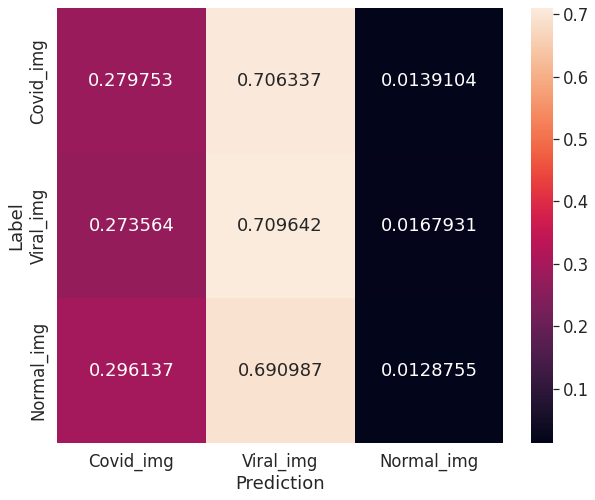

In [68]:
# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(np.concatenate(y_true),
                                         adj_pred_1,
                                         num_classes=3,
                                         weights=None)
confusion_mtx = confusion_mtx/confusion_mtx.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(10, 8))
sns.set(font_scale = 1.5)
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('matrix1.png')
plt.show()